# Layer-wise Relevance Propagation

See https://iphome.hhi.de/samek/pdf/MonXAI19.pdf

TODO: Rellenar info de cómo funciona LRP

> This notebooks gets the embeddings (or latent space) from a vultivariate time series given by an encoder (e.g. autoencoder) and uses them as input for a dimensionality reduction algorithm, to generate projections of the embeddings. (As 04.. does). Afterwards, it applies LRP to check the importance of each feature in the embeddings obtaiment. This check can be done by selecting some points in the plot and, afterwards, checking the importance for each feature in the obtainment of this part of the embedding.

## Dimensionality reduction

Generate projectsion of the embeddings

In [8]:
#Weight & Biases
import wandb

#Yaml
from yaml import load, FullLoader

#Embeddings
from dvats.all import *
from tsai.data.preparation import prepare_forecasting_data
from tsai.data.validation import get_forecasting_splits
from fastcore.all import *

#Dimensionality reduction
from tsai.imports import *

#Clustering
import hdbscan

In [9]:
check_memory_usage = True

In [10]:
if check_memory_usage:
    import nbs_pipeline.utils.memory as mem
    import torch 
    gpu_device = torch.cuda.current_device()
    mem.gpu_memory_status(gpu_device)

GPU | Used mem: 3
GPU | Used mem: 24576
GPU | Memory Usage: [--------------------] 0%


In [11]:
#Get W&B API
api = wandb.Api()

### Config parameters

Put here everything that could be needed if this notebook

TODO: Change to config.py & tml version when fixed

In [12]:
## Buscando una combinación buena
cpu_flag = False

if cpu_flag:
    n_neighbors = 15
    min_dist = 0.1
else: 
    n_neighbors = 15 #200
    min_dist = 0.1 #0.0001
    

In [13]:
config = AttrDict(
    use_wandb = False, # Whether to use or not wandb for experiment tracking
    wandb_group = None, # Whether to group this run in a wandb group
    wandb_entity = os.environ['WANDB_ENTITY'], # The entity to use for wandb,
    wandb_project = os.environ['WANDB_PROJECT'], # The project to use for wandb,
    dr_artifact_name = None, # * Set to None for using the default one (encoder validation set)
    enc_artifact = 'mi-santamaria/deepvats/mvp-SWV:latest', # Name:version of the encoder artifact
    n_neighbors = n_neighbors, #15, #UMAP
    min_dist = min_dist, #0.1, #UMAP,
    random_state = int(1234), # UMAP
    metric = 'euclidean',
    cpu = cpu_flag
)

This model needs to restore the encoder model fitted in the notebook `02x`, as well as the data and configuration

### Run DR

In [14]:
import os
path = os.path.expanduser("~/work/nbs_pipeline/")
name="04_dimensionality_reduction"
runname = name
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"

In [15]:
run_dr = wandb.init(
    entity=config.wandb_entity,
    project=config.wandb_project if config.use_wandb else 'work-nbs', 
    group=config.wandb_group,
    allow_val_change=True, 
    job_type='dimensionality_reduction', 
    mode='online' if config.use_wandb else 'disabled',
    anonymous = 'never' if config.use_wandb else 'must',
    config=config,
    resume = 'allow',
    name = runname
    #resume=False
)
config_dr = wandb.config # Object for storing hyperparameters

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /home/macu/work/nbs_pipeline/04_dimensionality_reduction.ipynb.


In [16]:
# Botch to use artifacts offline
artifacts_gettr = run.use_artifact if config_dr.use_wandb else api.artifact

Restore the encoder model and its associated configuration

In [17]:
enc_artifact = artifacts_gettr(config.enc_artifact, type='learner')
enc_artifact.metadata

{'r': 0.71,
 'w': 900,
 'MVP': {'r': 0.71,
  'lm': 3.0,
  'crit': None,
  'sync': False,
  'fname': 'encoder_MVP',
  'dropout': 0.1,
  'verbose': False,
  'stateful': True,
  'save_best': True,
  'nan_to_num': 0,
  'custom_mask': None,
  'future_mask': False,
  'weights_path': None,
  'variable_mask': False,
  'subsequence_mask': True},
 'ref': {'hash': '7181175851929983046',
  'type': "<class 'fastai.learner.Learner'>"},
 'freq': '4s',
 'alias': 'solar_4_seconds',
 'n_inp': 1,
 'device': 'cuda',
 'epochs': 100,
 'frozen': False,
 'mvp_ws': [450, 900],
 'stride': 450,
 'Learner': {'lr': 0.001,
  'wd': None,
  'arch': 'tsai.models.InceptionTimePlus.InceptionTimePlus',
  'moms': [0.95, 0.85, 0.95],
  'path': '.',
  '_name': '<fastai.learner.Learner object at 0x7f08587b3f10>',
  'metrics': None,
  'opt_func': 'fastai.optimizer.Adam',
  'splitter': 'tsai.models.utils.ts_splitter',
  'train_bn': True,
  'loss_func': {'axis': -1,
   '_name': {'axis': -1,
    '_name': 'FlattenedLoss of MSELos

In [18]:
enc_artifact.name

'mvp-SWV:v54'

In [19]:
# TODO: This only works when you run it two timeS! WTF?
try:
    enc_learner = enc_artifact.to_obj()
except:
    enc_learner = enc_artifact.to_obj()

wandb:   1 of 1 files downloaded.  


Restore the dataset artifact used for training the encoder. Even if we do not compute the dimensionality reduction over this dataset, we need to know the metadata of the encoder training set, to check that 
it matches with the dataset that we want to reduce.

In [20]:
enc_logger = enc_artifact.logged_by()
enc_artifact_train = artifacts_gettr(enc_logger.config['train_artifact'], type='dataset')
if enc_logger.config['valid_artifact'] is not None:
    enc_artifact_valid = artifacts_gettr(enc_logger.config['valid_artifact'], type='dataset')
    print("enc_artifact_valid:", enc_artifact_valid.name)
print("enc_artifact_train: ", enc_artifact_train.name)

enc_artifact_train:  solar_4_seconds-20s:v3


Now we specify the dataset artifact that we want to use for the reduction. If no artifact is defined, the artifact to reduce will be the one used for validate the encoder.

In [21]:
if config_dr.dr_artifact_name is not None:
    dr_artifact = artifacts_gettr(config_dr.dr_artifact_name)
else:
    dr_artifact = enc_artifact_train
dr_artifact.name

'solar_4_seconds-20s:v3'

Now we need to check whether the artifact that is going to be used fort the dimensionality reduction matches the artifact used to train the encoder. Matching means having the same number of variables, the same window size and stride, and the same frequency.

In [22]:
df = dr_artifact.to_df()
df.head()

wandb:   1 of 1 files downloaded.  


,0,1,2,3,4
2002-01-01 00:00:00,4995.400909,3476.007487,3156.216405,1093.949562,302.794642
2002-01-01 00:00:20,3923.444920,2885.023318,2777.034856,789.073860,277.451848
2002-01-01 00:00:40,4129.310217,2733.710683,2884.988168,736.149227,301.431725
2002-01-01 00:01:00,5329.409519,2877.257957,3593.461371,780.097337,377.047302
2002-01-01 00:01:20,6150.810094,3060.637287,4012.004044,849.544364,406.177858


In [23]:
type(df)

pandas.core.frame.DataFrame

In [24]:
print(df.shape)
print(np.round(df.shape[0]/ 1e6, 1))
print(np.round(df.shape[0]/ 1e3, 1))

(46455, 5)
0.0
46.5


In [25]:
show_time_series_flag = False
if show_time_series_flag:
    # Show time series plot
    fig, ax = plt.subplots(1, figsize=(15,5), )
    cmap = matplotlib.colormaps.get_cmap('viridis')
    df.plot(color=cmap(0.05), ax=ax) # or use colormap=cmap
    # rect = Rectangle((5000, -4.2), 3000, 8.4, facecolor='lightgrey', alpha=0.5)
    # ax.add_patch(rect)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [26]:
import time

In [27]:
w = enc_logger.config['w']
print(w)

900


In [28]:
if check_memory_usage: mem.gpu_memory_status(gpu_device)

GPU | Used mem: 3
GPU | Used mem: 24576
GPU | Memory Usage: [--------------------] 0%


In [29]:
t_start = time.time()
enc_input, _ = prepare_forecasting_data(df, fcst_history = w)
t_end = time.time()
t = t_end - t_start
print("SW start | " , t_start, " | end ", t_end, "total (secs): ", t)
print(enc_input.shape)

SW start |  1706036545.752804  | end  1706036545.7535622 total (secs):  0.0007581710815429688
(45555, 5, 900)


In [30]:
if check_memory_usage: mem.gpu_memory_status(gpu_device)

GPU | Used mem: 3
GPU | Used mem: 24576
GPU | Memory Usage: [--------------------] 0%


### Getting the embeddings (activations) from the encoder

In [31]:
stride = enc_logger.config['stride']
batch_size = enc_logger.config['batch_size']

In [32]:
print(stride)
print(batch_size)

450
512


In [33]:
print(enc_input.shape)
print(enc_artifact.name)

(45555, 5, 900)
mvp-SWV:v54


In [34]:
if check_memory_usage: mem.gpu_memory_status(gpu_device)

GPU | Used mem: 3
GPU | Used mem: 24576
GPU | Memory Usage: [--------------------] 0%


In [35]:
i = 0
for a in range (enc_input.shape[0]):
    for b in range (enc_input.shape[1]):
        for c in range (enc_input.shape[2]):
            if enc_input[a,b,c] != 0: 
                print(a,b,c, enc_input[a,b,c])
                i+=1
                if i == 10: break
        if i == 10: break
    if i == 10: break

0 0 0 4995.4009088
0 0 1 3923.4449196
0 0 2 4129.3102168
0 0 3 5329.4095192
0 0 4 6150.8100944
0 0 5 6429.087605999999
0 0 6 6782.334766800001
0 0 7 6687.411101200001
0 0 8 6295.6479112
0 0 9 5356.735308400001


In [36]:
chunk_max = 10000000
shape = enc_input.shape
chunk_size_ = min(shape[1]*shape[2],chunk_max/(shape[1]*shape[2]))
N = max(3200,np.floor(chunk_size_/32))
chunk_size = N*32
chunk_size

102400

In [37]:
t_start = time.time()
embs = get_enc_embs_set_stride_set_batch_size(
    enc_input, 
    enc_learner, 
    stride = stride,
    batch_size = batch_size,
    cpu=config.cpu,
    to_numpy = True, 
    print_flag = False,
    time_flag = True,
    chunk_size = chunk_size
)
t_end = time.time()
t = t_end-t_start
print("GE start | " , t_start, " | end ", t_end, "total (secs): ", t)

get_enc_embs_set_stride_set_batch_size 3.0291285514831543 seconds
GE start |  1706036546.0277445  | end  1706036549.0635414 total (secs):  3.035796880722046


In [38]:
beep(0.05)

In [39]:
embs.shape

(102, 128)

In [40]:
embs[0,0:20]

array([7.1799934e-01, 0.0000000e+00, 8.8659954e-01, 1.1302404e-01,
       8.3098274e-01, 1.8864704e-02, 0.0000000e+00, 1.9684386e-02,
       2.0053786e-04, 0.0000000e+00, 1.7567955e-04, 6.1251289e-01,
       1.4898642e-03, 0.0000000e+00, 2.1787526e-01, 8.9107017e-04,
       0.0000000e+00, 0.0000000e+00, 8.9796400e-01, 0.0000000e+00],
      dtype=float32)

In [41]:
t_end = time.time()
t = t_end-t_start
print("GE start | " , t_start, " | end (next cell) ", t_end, "total (secs): ", t)

GE start |  1706036546.0277445  | end (next cell)  1706036550.1150568 total (secs):  4.0873122215271


In [42]:
if check_memory_usage: mem.gpu_memory_status(gpu_device)

GPU | Used mem: 3
GPU | Used mem: 24576
GPU | Memory Usage: [--------------------] 0%


In [43]:
run_dr.finish()

In [44]:
#Restart kernel (Debugging code 4 analysing where can app be failing. Expecting to be related to GPU mem ussage)
#os._exit(00)

### Dimensions check

In [45]:
print(embs.shape)
print(enc_input.shape)

(102, 128)
(45555, 5, 900)


In [46]:
embs[0][:10]

array([7.1799934e-01, 0.0000000e+00, 8.8659954e-01, 1.1302404e-01,
       8.3098274e-01, 1.8864704e-02, 0.0000000e+00, 1.9684386e-02,
       2.0053786e-04, 0.0000000e+00], dtype=float32)

In [47]:
#Dimensions check
num_inputs = np.ceil(enc_input.shape[0]/stride)
num_embs = embs.shape[0]
test_eq(num_inputs, num_embs )
print(num_inputs, num_embs)

102.0 102


Average embeddings in the time dimension, if needed

## Dimensionality reduction using UMAP

We use DR techniques to provide an alternative view for users to visually analyze and explore the time-series data. The algorithm UMAP shows its high competitiveness compared to t-SNE. t-SNE suffers from some limitations such as loss of large-scale information (the inter-cluster relationships). UMAP has a faster runtime and provides better scaling which helps to gain a meaningful organization of clusters, outliers and the preservation of continuums compared to t-SNE

For this part of the implementation, the package [umap-learn](https://github.com/lmcinnes/umap) is used. The input of the algoritm is the $n \times \delta$ that contains, for each slice of the time series, the corresponding $\delta$ latent embeddings given by the encoder.

The hyperparameters of UMAP are given values by default here. If the value has been already set previously, that means this notebook is being called from a wandb sweep, and we must use the value that the sweep is bringing.

In [48]:
if cpu_flag:
    umap_params = {
        'n_neighbors' : config_dr.n_neighbors,
        'min_dist' : config_dr.min_dist,
        'random_state': np.uint64(1234), 
        'metric': config_dr.metric,
        'a': 1.5769434601962196,
        'b': 0.8950608779914887,
        #'metric_kwds': {'p': 2}, #No debería ser necesario, just in case
        'output_metric': 'euclidean',
        'verbose': 4,
        'n_epochs': 200
    }
else:
    umap_params = {
        'n_neighbors' : config_dr.n_neighbors,
        'min_dist' : config_dr.min_dist,
        'random_state': np.uint64(1234), 
        'metric': config_dr.metric,
        'a': 1.5769434601962196,
        'b': 0.8950608779914887,
        'target_metric': 'euclidean',
        'target_n_neighbors': config_dr.n_neighbors,
        'verbose': 6,
        'n_epochs': 200
    }






check_reducer = True
import utils.config as cfg_
if check_reducer:
    import umap
    import cuml
    print("-- umap.UMAP --", cpu_flag)
    reducer1 = umap.UMAP(force_approximation_algorithm = True, **umap_params)
    print("-- cuml.UMAP --", cpu_flag)
    reducer2 = cuml.UMAP(**umap_params)
    print("------- reducer1 --------")
    print(reducer1)
    params1=AttrDict(reducer1.get_params())
    print("------- reducer2 --------")
    print(reducer2)
    params2=AttrDict(reducer2.get_params())
    print("------- reducer2 --------")
    cfg_.diff_attrdict(dict_original=params2, dict_modified=params1, both=True)
    beep(0.10)

#if not cpu_flag:
    #umap_params['force_approximation_algorithm'] = True # Este no parece ser el influencer
    #umap_params['angular_rp_forest'] = True #No es el influencer

#if params2['random_state'] != 1234:
 #   raise Exception("Wrong random_state params")

-- umap.UMAP -- False
-- cuml.UMAP -- False
------- reducer1 --------
UMAP(a=1.5769434601962196, b=0.8950608779914887, force_approximation_algorithm=True, n_epochs=200, random_state=1234, target_metric='euclidean', target_n_neighbors=15, verbose=6)
------- reducer2 --------
UMAP()
------- reducer2 --------
callback is missing in modified dict | 0 
dens_frac is missing in original dict | 0.3 
a: 1.5769434601962196
precomputed_knn: None -> (None, None, None)
output_type is missing in modified dict | 0 
verbose: 6
init: spectral
tqdm_kwds is missing in original dict | None 
negative_sample_rate: 5
transform_mode is missing in original dict | embedding 
dens_var_shift is missing in original dict | 0.1 
min_dist: 0.1
angular_rp_forest is missing in original dict | False 
handle is missing in modified dict | 0 
local_connectivity: 1.0
target_weight: 0.5
transform_queue_size: 4.0
set_op_mix_ratio: 1.0
low_memory is missing in original dict | True 
output_dens is missing in original dict | Fal

In [49]:
#Ensure no nan ((Intento de Macu. La celda de comentada abajo es la original. Pero falla por Nan con sunspot))
embs_no_nan = embs[~np.isnan(embs).any(axis=1)]
embs_no_nan.shape

(101, 128)

In [50]:
umap_params_cpu = {
        'n_neighbors' : config_dr.n_neighbors,
        'min_dist' : config_dr.min_dist,
        'random_state': np.uint64(1234), 
        'metric': config_dr.metric,
        #'a': 1.5769434601962196,
        #'b': 0.8950608779914887,
        #'metric_kwds': {'p': 2}, #No debería ser necesario, just in case
        #'output_metric': 'euclidean',
        'verbose': 4,
        #'n_epochs': 200
    }
umap_params_gpu = {
        'n_neighbors' : config_dr.n_neighbors,
        'min_dist' : config_dr.min_dist,
        'random_state': np.uint64(1234), 
        'metric': config_dr.metric,
        'a': 1.5769434601962196,
        'b': 0.8950608779914887,
        'target_metric': 'euclidean',
        'target_n_neighbors': config_dr.n_neighbors,
        'verbose': 4, #6, #CUML_LEVEL_TRACE
        'n_epochs': 200*3*2,
        'init': 'random',
        'hash_input': True
    }


if cpu_flag:
    umap_params = umap_params_cpu
else:
    umap_params = umap_params_gpu

umap_params


{'n_neighbors': 15,
 'min_dist': 0.1,
 'random_state': 1234,
 'metric': 'euclidean',
 'a': 1.5769434601962196,
 'b': 0.8950608779914887,
 'target_metric': 'euclidean',
 'target_n_neighbors': 15,
 'verbose': 4,
 'n_epochs': 1200,
 'init': 'random',
 'hash_input': True}

In [51]:
embs_no_nan.shape

(101, 128)

In [52]:
prjs_pca = get_PCA_prjs(
    X = embs_no_nan, 
    cpu = cpu_flag, #config_dr.cpu, 
    print_flag = True, 
    #target_weight=1,
    **umap_params
)
prjs_pca.shape

[I] [19:02:31.424765] Unused keyword parameter: print_flag during cuML estimator initialization
[I] [19:02:31.425142] Unused keyword parameter: n_neighbors during cuML estimator initialization
[I] [19:02:31.425342] Unused keyword parameter: min_dist during cuML estimator initialization
[I] [19:02:31.425538] Unused keyword parameter: metric during cuML estimator initialization
[I] [19:02:31.425724] Unused keyword parameter: a during cuML estimator initialization
[I] [19:02:31.425916] Unused keyword parameter: b during cuML estimator initialization
[I] [19:02:31.426110] Unused keyword parameter: target_metric during cuML estimator initialization
[I] [19:02:31.426336] Unused keyword parameter: target_n_neighbors during cuML estimator initialization
[I] [19:02:31.426546] Unused keyword parameter: n_epochs during cuML estimator initialization
[I] [19:02:31.426734] Unused keyword parameter: init during cuML estimator initialization
[I] [19:02:31.426916] Unused keyword parameter: hash_input d

(101, 101)

In [53]:
prjs_umap = get_UMAP_prjs(
    input_data = prjs_pca, 
    cpu = cpu_flag, #config_dr.cpu, 
    print_flag = True, 
    #target_weight=1,
    **umap_params
)
prjs_umap.shape

--> get_UMAP_prjs
kwargs:  {'n_neighbors': 15, 'min_dist': 0.1, 'random_state': 1234, 'metric': 'euclidean', 'a': 1.5769434601962196, 'b': 0.8950608779914887, 'target_metric': 'euclidean', 'target_n_neighbors': 15, 'verbose': 4, 'n_epochs': 1200, 'init': 'random', 'hash_input': True}
eccc1509e59b8b19cb4c89bf1fe8ddd2
GPU | Used mem: 3
GPU | Used mem: 24576
GPU | Memory Usage: [--------------------] 0%
-- cuml.UMAP -- False
------- reducer --------
UMAP()
{'handle': <pylibraft.common.handle.Handle object at 0x7fcd4ff910e0>, 'verbose': 4, 'output_type': 'input', 'n_neighbors': 15, 'n_components': 2, 'n_epochs': 1200, 'learning_rate': 1.0, 'min_dist': 0.1, 'spread': 1.0, 'set_op_mix_ratio': 1.0, 'local_connectivity': 1.0, 'repulsion_strength': 1.0, 'negative_sample_rate': 5, 'transform_queue_size': 4.0, 'init': 'random', 'a': 1.5769434601962196, 'b': 0.8950608779914887, 'target_n_neighbors': 15, 'target_weight': 0.5, 'target_metric': 'euclidean', 'hash_input': True, 'random_state': 1234, '

(101, 2)

In [54]:
beep(0.15)
beep(0.15)
beep(0.15)


In [55]:
prjs_umap[0:10] # En R head(res[1,],10)

array([[ 0.19972992,  2.2171335 ],
       [-0.03229237,  2.3264122 ],
       [ 0.7889681 , -1.2833548 ],
       [ 1.7434816 , -3.84402   ],
       [ 0.80975723, -1.4006796 ],
       [-0.2989335 ,  2.307188  ],
       [ 0.03794098,  2.4101486 ],
       [ 0.31207466,  1.8651466 ],
       [ 0.2763815 ,  1.8012171 ],
       [-0.1265049 ,  2.1768322 ]], dtype=float32)

In [56]:
#prjs = get_UMAP_prjs(embs, cpu=False, **umap_params)
#prjs.shape

Save the projections as an artifact

In [57]:
if config.use_wandb: 
    run.log_artifact(ReferenceArtifact(prjs, 'projections', type='projections', 
metadata=dict(run_dr.config)), aliases=f'run-{run.project}-{run.id}')

## Create Precomputed Clusters

In order to integrate precomputed clusters into the embedding space, it's necessary to log artifacts that include the labels of the newly created clusters. 

The cluster creation process is presented below. This creation procedure can be modified according to specific needs. However, the structure of the new artifact must be preserved (it must be a numpy.ndarray and the number of elements must be equal to the number of points in the embedding space).

In [58]:
print(f'HDBSCAN supported metrics: {list(hdbscan.dist_metrics.METRIC_MAPPING.keys())}')

HDBSCAN supported metrics: ['euclidean', 'l2', 'minkowski', 'p', 'manhattan', 'cityblock', 'l1', 'chebyshev', 'infinity', 'seuclidean', 'mahalanobis', 'wminkowski', 'hamming', 'canberra', 'braycurtis', 'matching', 'jaccard', 'dice', 'kulsinski', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath', 'haversine', 'cosine', 'arccos', 'pyfunc']


In [59]:
# Define HDBSCAN parameters
hdbscan_kwargs = {
    'min_cluster_size' : 7, #100, #100,
    'min_samples' : 3,
    'cluster_selection_epsilon' : 0.0001,
}
metric_kwargs = {
    'metric' : 'euclidean' #'jaccard'
}

In [60]:
# Create clusters using HDBSCAN
clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs_umap)
clusters_labels = clusters.labels_
list(Counter(clusters_labels).items())

[(2, 11), (1, 49), (0, 21), (3, 20)]

### Check cluster score

In [61]:
score = cluster_score(prjs_umap, clusters_labels, True)

Silhouette_score: 0.5653823


In [62]:
# Testing artifact structure 
test_eq_type(type(clusters_labels), np.ndarray)
test_eq(clusters_labels.size, prjs_umap.shape[0])

In [63]:
# Create and log 'clusters_labels' artifact
clusters_ar = ReferenceArtifact(obj=clusters_labels, name='clusters_labels')
clusters_ar.metadata, clusters_ar.manifest.entries.values()

({'ref': {'hash': '7962898824688195370', 'type': "<class 'numpy.ndarray'>"}},
 dict_values([ArtifactManifestEntry(path='7962898824688195370', digest='ayNGOg1sR3TGEVj97aAoIg==', ref='file:///home/macu/data/wandb_artifacts/7962898824688195370', birth_artifact_id=None, size=958, extra={}, local_path=None)]))

In [64]:
run_dr.log_artifact(clusters_ar, aliases=['hdbscan_jaccard'])

## 2D Visualization 

While the connected scatter plot is a simple visualization technique, it has very specific functions in our approach. Every sliding window is represented as a dot in the plot after the projection process (Fig. 4C, D of the paper). Before labeling, all points have the same color and transparency, and when they are concentrated in one area, the densities are accumulated. Lines are used to connect consecutive points preserving the temporal ordering of the data and allowing the user to see temporal connections (Fig. 4B of the paper). Thus, the point is linked to the previous point (inner) and to the posterior point (outer) as an indication of the flow of time.

In [65]:
#| export
def plot_projections(prjs, umap_params, fig_size = (25,25)):
    "Plot 2D projections thorugh a connected scatter plot"
    df_prjs = pd.DataFrame(prjs, columns = ['x1', 'x2'])
    fig = plt.figure(figsize=(fig_size[0],fig_size[1]))
    ax = fig.add_subplot(111)
    ax.scatter(df_prjs['x1'], df_prjs['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
    ax.plot(df_prjs['x1'], df_prjs['x2'], alpha=0.5, picker=1)
    plt.title('DR params -  n_neighbors:{:d} min_dist:{:f}'.format(
        umap_params['n_neighbors'],umap_params['min_dist']))
    return ax

In [66]:
#| export
def plot_projections_clusters(prjs, clusters_labels, umap_params, fig_size = (25,25)):
    "Plot 2D projections thorugh a connected scatter plot"
    df_prjs = pd.DataFrame(prjs, columns = ['x1', 'x2'])
    df_prjs['cluster'] = clusters_labels
    
    fig = plt.figure(figsize=(fig_size[0],fig_size[1]))
    ax = fig.add_subplot(111)
    
    # Create a scatter plot for each cluster with different colors
    unique_labels = df_prjs['cluster'].unique()
    print(unique_labels)
    for label in unique_labels:
        cluster_data = df_prjs[df_prjs['cluster'] == label]
        ax.scatter(cluster_data['x1'], cluster_data['x2'], label=f'Cluster {label}')
        #ax.scatter(df_prjs['x1'], df_prjs['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
    
    #ax.plot(df_prjs['x1'], df_prjs['x2'], alpha=0.5, picker=1)
    plt.title('DR params -  n_neighbors:{:d} min_dist:{:f}'.format(
        umap_params['n_neighbors'],umap_params['min_dist']))
    return ax

[2 1 0 3]


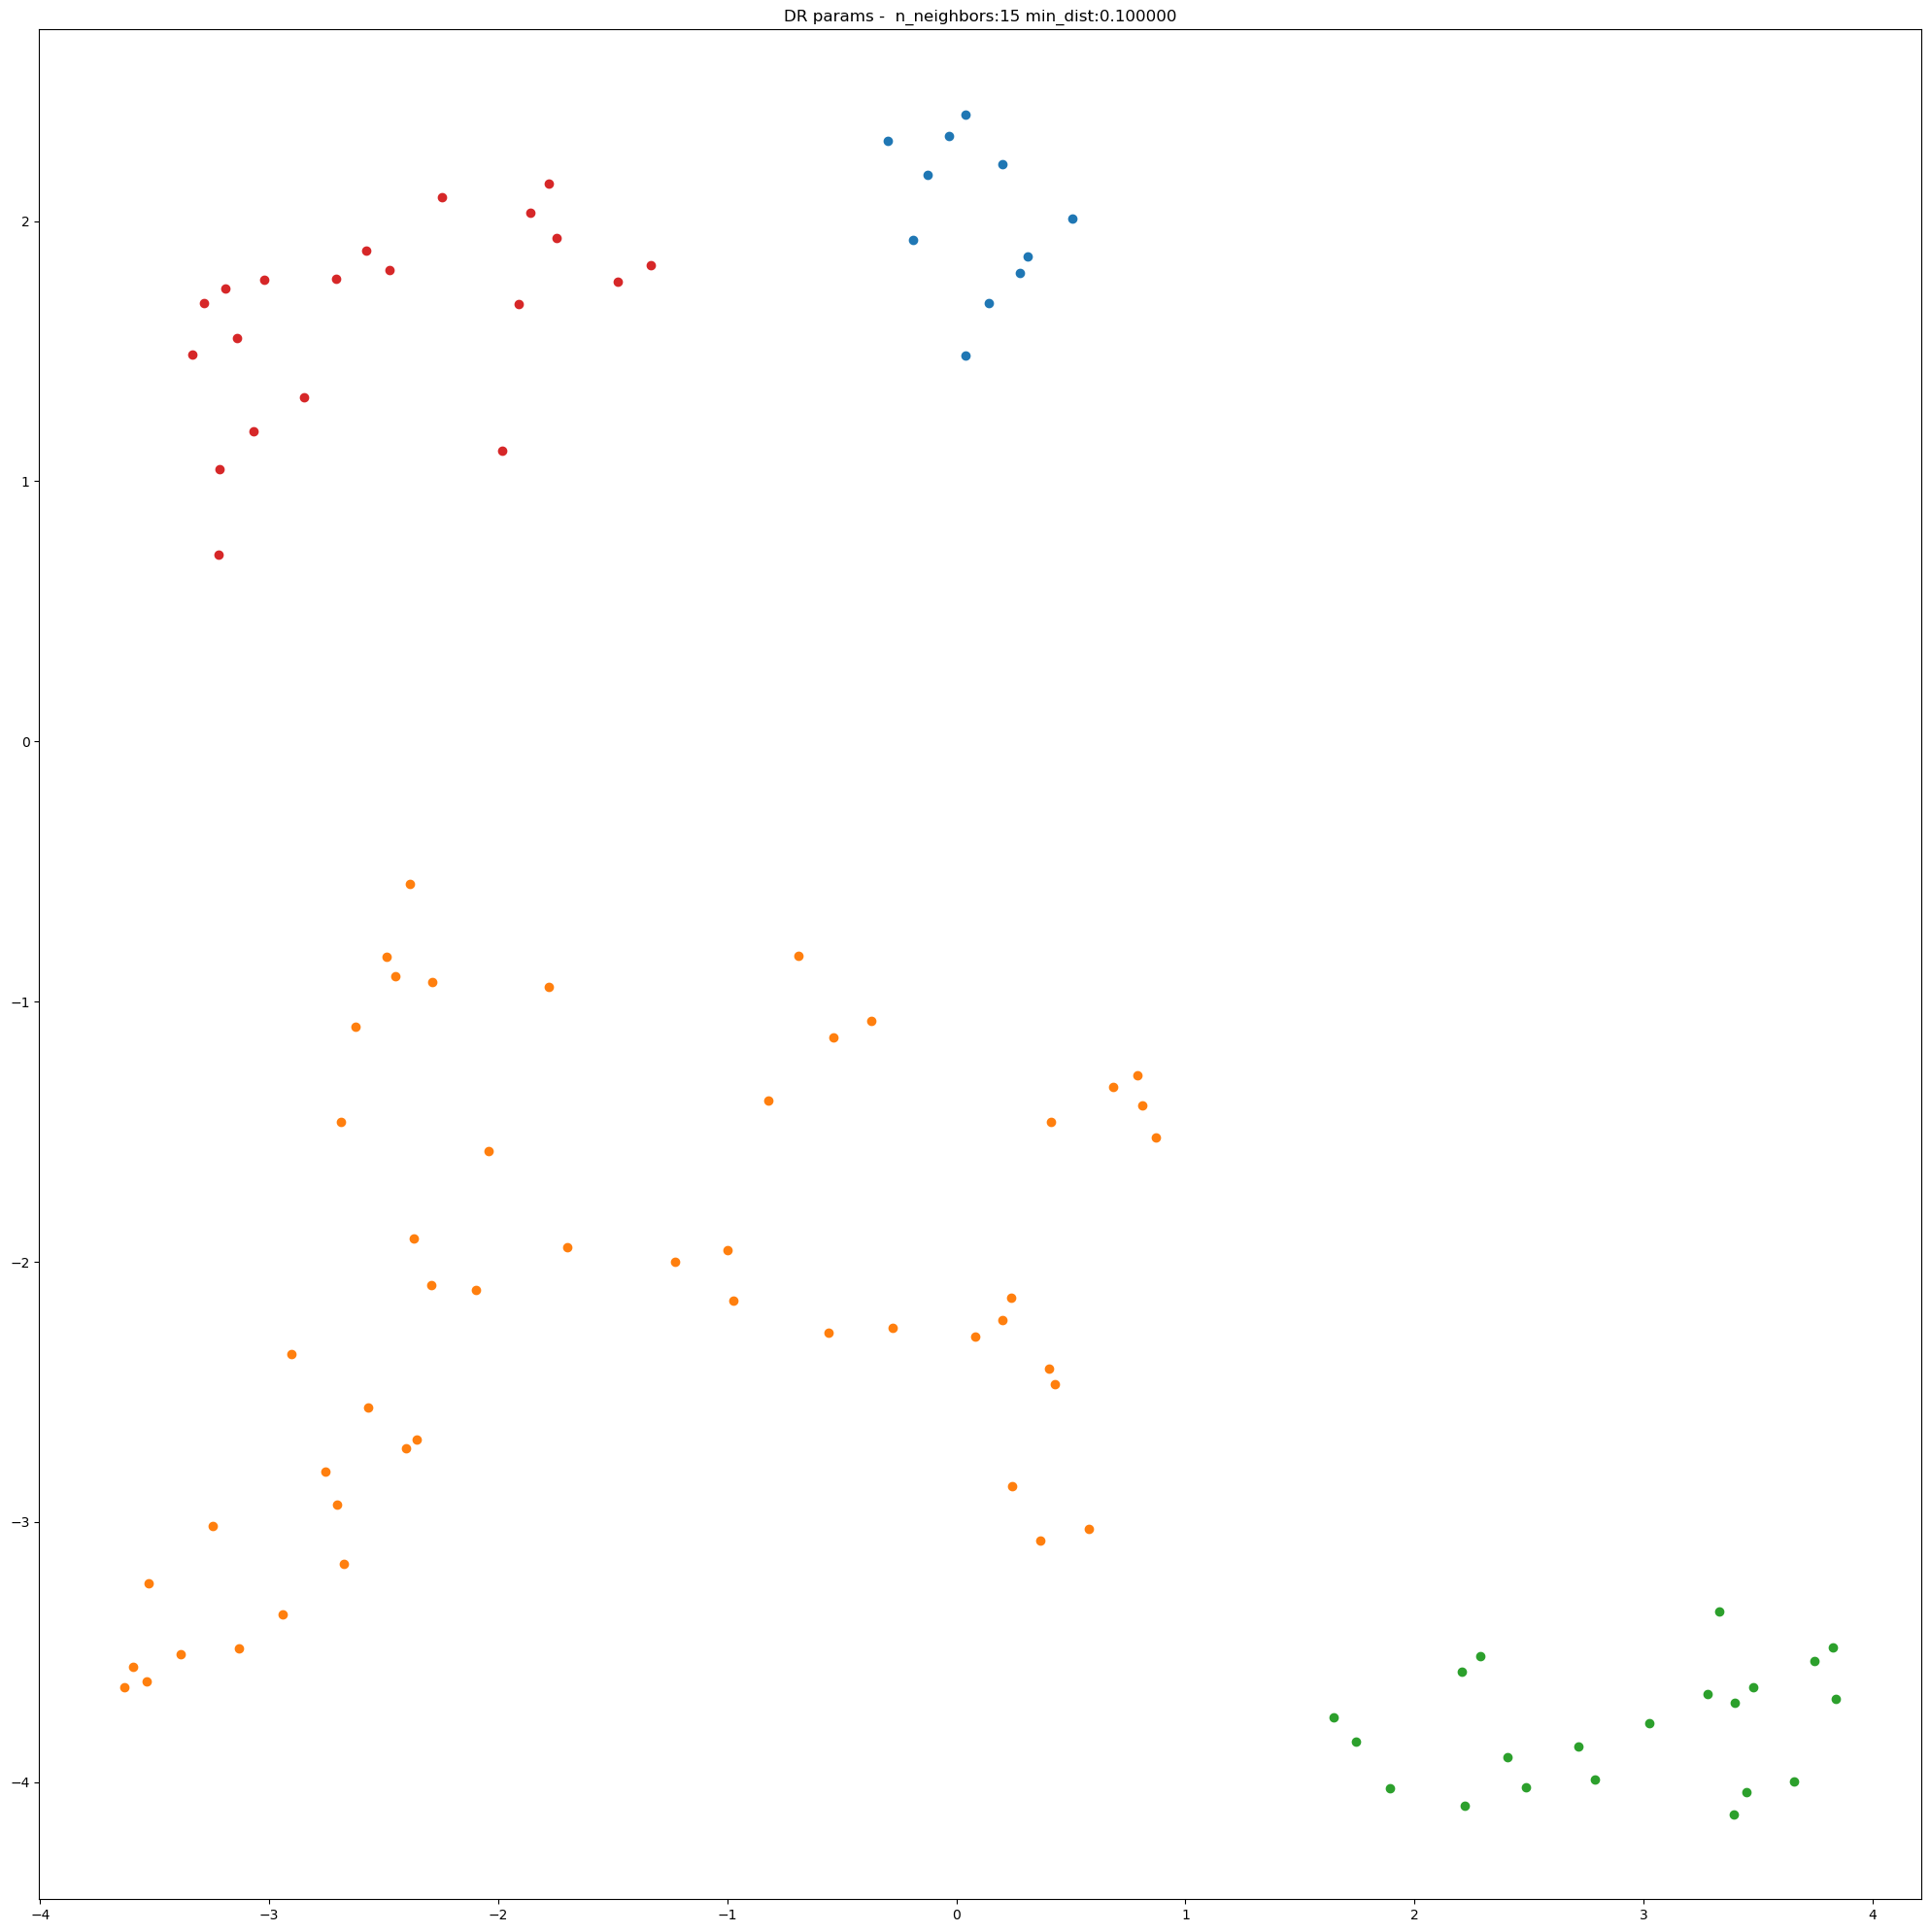

In [67]:
prjs_plt = plot_projections_clusters(prjs_umap, clusters_labels, umap_params)

In [68]:
beep(0.25)
beep(0.25)
beep(0.25)

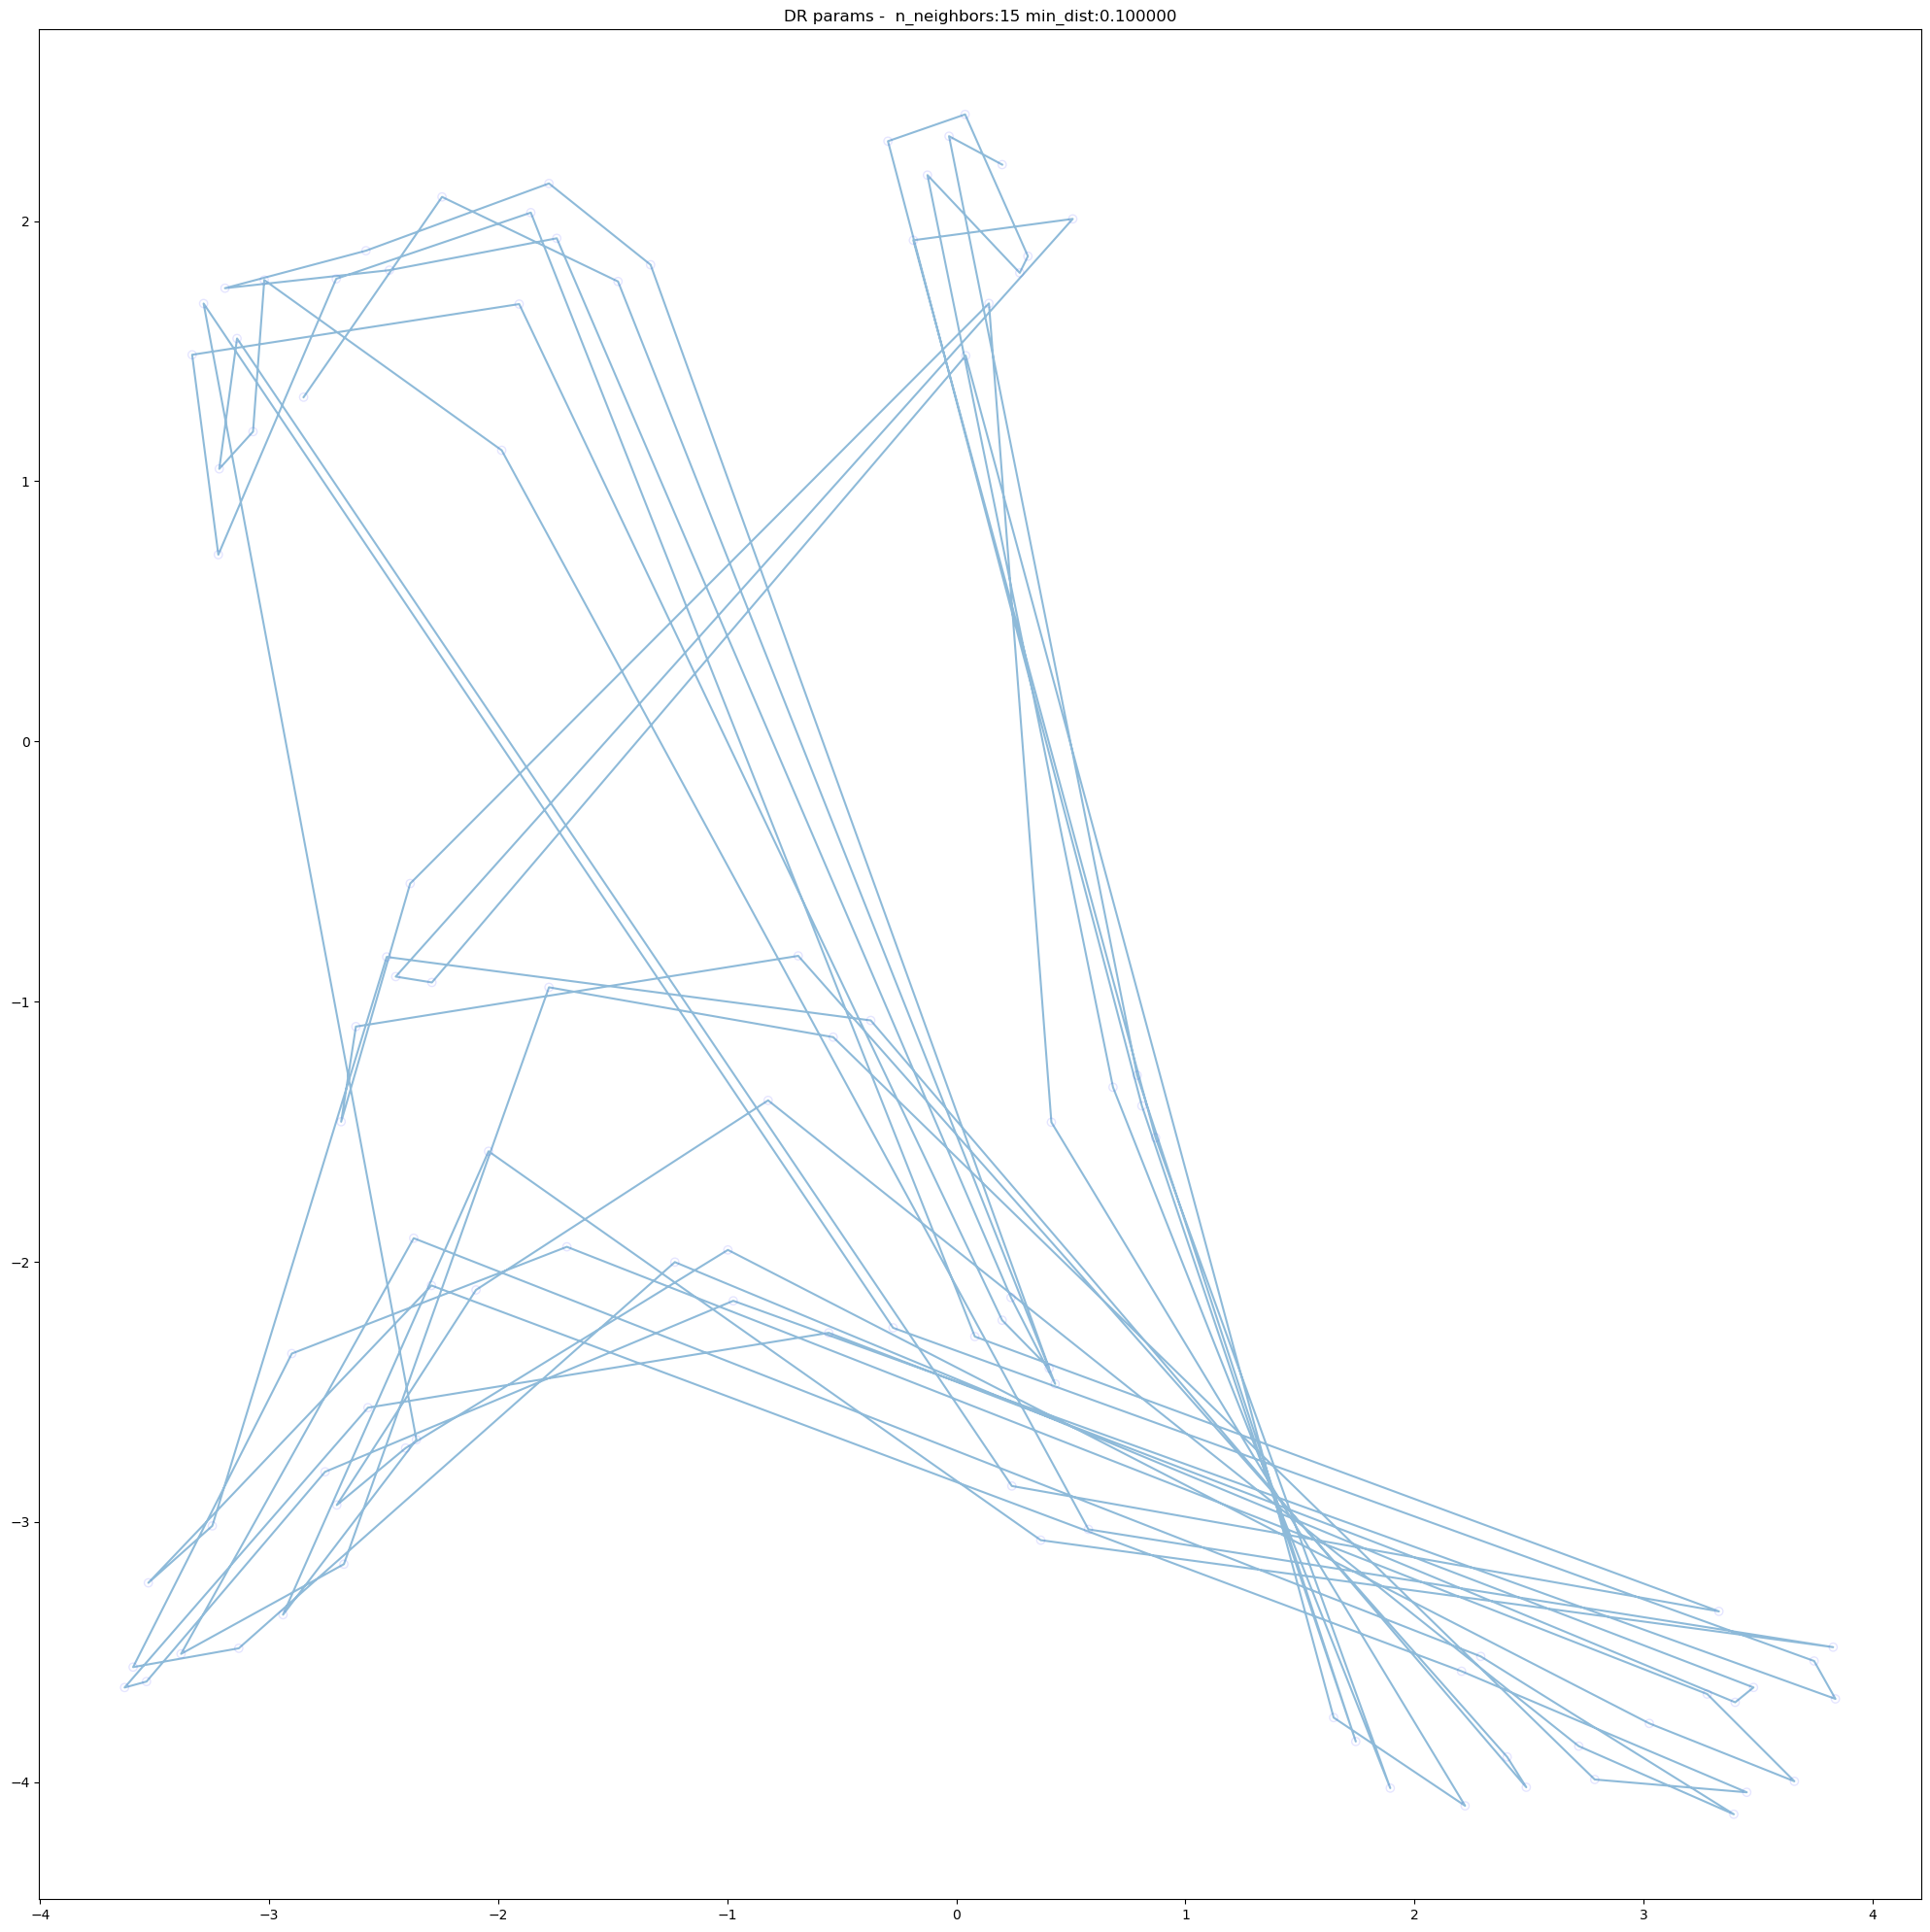

In [69]:
prjs_plt = plot_projections(prjs_umap, umap_params)

Log this plot as part of the current wandb run

In [70]:
#| hide

# Get the figure of the embedding plot, and save it on thea wandb run.
run_dr.log({"img": [wandb.Image(prjs_plt.get_figure(), caption="dr_projections_plot")]})

#run_dr.log({'embeddings_plot': embeddings_plot})

In [71]:
#| hide
run_dr.finish()

## Anomalies simple detector: dynamic plot for determining whether a window of time series is anomalous

#### Get Anomaly Score

In [72]:
# Create clusters using HDBSCAN
clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs_umap)
clusters_labels = clusters.labels_
list(Counter(clusters_labels).items())

[(2, 11), (1, 49), (0, 21), (3, 20)]

In [73]:
def calculate_cluster_stats(data, labels):
    """Computes the media and the standard deviation for every cluster."""
    cluster_stats = {}
    for label in np.unique(labels):
        #members = data[labels == label]
        members = data
        mean = np.mean(members, axis = 0)
        std = np.std(members, axis = 0)
        cluster_stats[label] = (mean, std)
    return cluster_stats

In [74]:
def anomaly_score(point, cluster_stats, label):
    """Computes an anomaly score for each point."""
    mean, std = cluster_stats[label]
    return np.linalg.norm((point - mean) / std)

In [75]:
def detector(data, labels):
    """Anomaly detection function."""
    cluster_stats = calculate_cluster_stats(data, labels)
    scores = []
    for point, label in zip(data, labels):
        score = anomaly_score(point, cluster_stats, label)
        scores.append(score)
    return np.array(scores)

In [76]:
anomaly_scores = detector(prjs_umap, clusters_labels)

### Check anomaly scores distribution

In [77]:
def plot_anomaly_scores_distribution(anomaly_scores):
    "Plot the distribution of anomaly scores to check for normality"
    plt.figure(figsize=(10, 6))
    sns.histplot(anomaly_scores, kde=True, bins=30)
    plt.title("Distribución de Anomaly Scores")
    plt.xlabel("Anomaly Score")
    plt.ylabel("Frecuencia")
    plt.show()

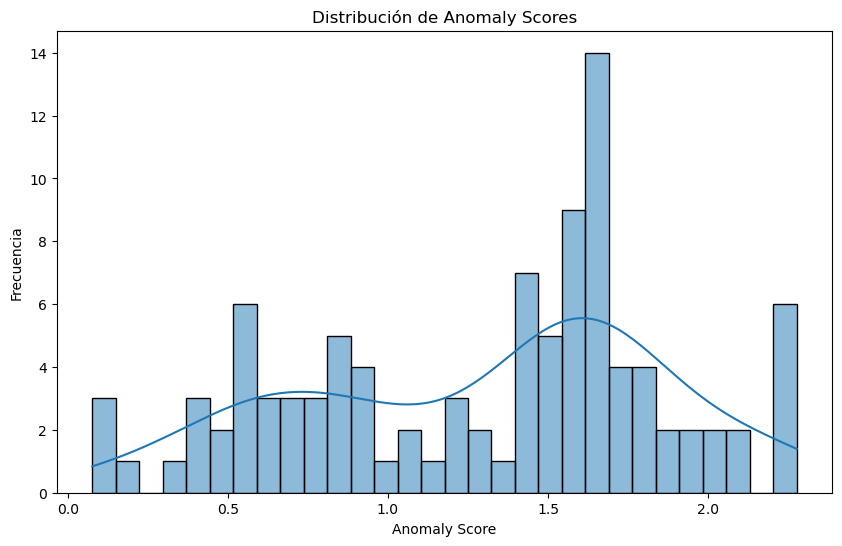

In [78]:
import seaborn as sns
plot_anomaly_scores_distribution(anomaly_scores)

## Select a threshold

In [79]:
print(anomaly_scores.shape)
print("min ", np.min(anomaly_scores))
print("max ", np.max(anomaly_scores))
anomaly_scores_mean = np.mean(anomaly_scores)
print("media ", anomaly_scores_mean)
anomaly_scores_std = np.std(anomaly_scores)
print("std ", anomaly_scores_std)

(101,)
min  0.07606738
max  2.277169
media  1.2968054
std  0.56417745


In [80]:
num_std = 2
threshold = anomaly_scores_mean + num_std * anomaly_scores_std
print("Threshold: ", threshold)

Threshold:  2.42516028881073


### Plot the anomalies

In [81]:
#| export
def plot_clusters_with_anomalies(prjs, clusters_labels, anomaly_scores, threshold, fig_size=(25, 25)):
    "Plot 2D projections of clusters and superimpose anomalies"
    df_prjs = pd.DataFrame(prjs, columns=['x1', 'x2'])
    df_prjs['cluster'] = clusters_labels
    df_prjs['anomaly'] = anomaly_scores > threshold

    fig = plt.figure(figsize=(fig_size[0], fig_size[1]))
    ax = fig.add_subplot(111)

    # Plot each cluster with different colors
    unique_labels = df_prjs['cluster'].unique()
    for label in unique_labels:
        cluster_data = df_prjs[df_prjs['cluster'] == label]
        ax.scatter(cluster_data['x1'], cluster_data['x2'], label=f'Cluster {label}', alpha=0.7)

    # Superimpose anomalies
    anomalies = df_prjs[df_prjs['anomaly']]
    ax.scatter(anomalies['x1'], anomalies['x2'], color='red', label='Anomalies', edgecolor='k', s=50)

    plt.title('Clusters and anomalies')
    plt.legend()
    plt.show()


In [82]:
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from functools import partial
fig_size = (7,7)
def update_plot(threshold):
    plot_clusters_with_anomalies(prjs_umap, clusters_labels, anomaly_scores, threshold, fig_size)

In [83]:
threshold_slider = widgets.FloatSlider(value=2, min=1, max=3, step=0.01, description='Threshold')
widgets.interactive(update_plot, threshold=threshold_slider)

interactive(children=(FloatSlider(value=2.0, description='Threshold', max=3.0, min=1.0, step=0.01), Output()),…

#### Using quartiles for the scores

In [84]:
def detect_anomalies_using_iqr(scores):
    # First and third quartiles
    Q1 = np.percentile(scores, 25)
    Q3 = np.percentile(scores, 75)
    # IQR range
    IQR = Q3 - Q1
    
    #Limits for anomalies
    factor = 1.5
    lower_bound = Q1 - (factor * IQR)
    upper_bound = Q3 + (factor * IQR)
    
    # Get anomalies
    anomalies = (scores < lower_bound) | (scores > upper_bound)
    
    return anomalies, lower_bound, upper_bound

In [85]:
anomalies, lower_bound, upper_bound = detect_anomalies_using_iqr(anomaly_scores)

print("Lower Bound for Anomalies:", lower_bound)
print("Upper Bound for Anomalies:", upper_bound)

Lower Bound for Anomalies: -0.4253609776496887
Upper Bound for Anomalies: 2.9472619891166687


In [86]:
def plot_data_with_anomalies(data, anomalies):
    plt.scatter(data[:, 0], data[:, 1], color='blue', label='Normal Data')
    plt.scatter(data[anomalies, 0], data[anomalies, 1], color='red', label='Anomalies')
    plt.title('Data with Anomalies highlighted')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

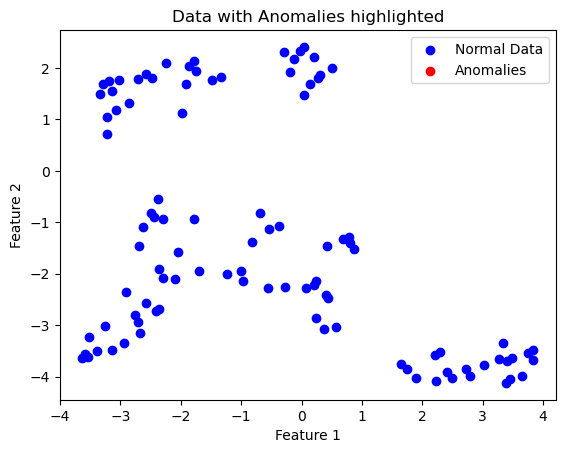

In [87]:
plot_data_with_anomalies(prjs_umap, anomalies)

## LRP

<span style="color:red; display:block;">

**Si alguien puede revisarme que no me he equivocado al hacer el seguimiento... que son muchas líneas**

Hay que tener en cuenta que MVP tiene dos capas (layer):

- **Backbone**, de la que salen los embeddings.
  
  Transforma y normaliza los datos. (Codifica)
  
  Dentro se llaman a los siguientes modelos:
  -  **nn.ReLU**(act_kwargs = {})
  -  **BatchNorm1d** (nf = 128)
  -  **BatchNorm1d** (nf = 32)
  -  **Conv1d**(n_in	= n_vars, nf = 128, ks = 1, bias = False, stride = 1, padding = 'same') SI n_vars != 128
  -  **Conv1d**(n_in	= n_vars, nf = 32, ks = 1, bias = False, stride = 1, padding = 'same') SI n_vars != 32
-  **Head**:
   - **SigmoidRange**(X_min, X_max) X = enc_input

     Escala las salidas al rango de valores de enc_input
   - **AdaptativePool1d**(n_out = 1)

     Reduce la dimensionalidad de los datos de entrada, devolviendo un array de tamaño (n_samples, n_vars, 1)
</span>

In [88]:
# Meter en dependencies de conda
! pip install zennit

In [89]:
enc_input.shape

(45555, 5, 900)

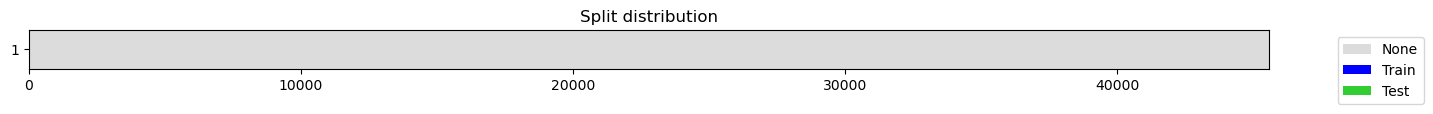

In [90]:
splits = get_forecasting_splits(
        df = df, 
        fcst_history = enc_artifact.metadata['w'],
        fcst_horizon = 1,
        stride = enc_artifact.metadata['stride'], 
        test_size = 0.2,
        show_plot = True
    )

In [91]:
enc_learner

### Zennit

#### Introduction

[Zennit](https://zennit.readthedocs.io/en/latest/getting-started.html) is a library that implements **propagation-based attribution methods** by *overwriting the gradient of PyTorch modules* in PyTorch's auto-differentiation engine (the part associated to the automatic gradient calculus of 'complex' functions).  Zennit uses this engine for modifying the way gradients are computed within the attribution process, allowing to apply attribution methods based on propagation. 

*Zennit will only work on models which are strictly implemented using Pytorch modules. Including activation functions.*

##### Attribution process
The "attribution process" in the context of neural networks and machine learning refers to the technique of determining how different parts of the input to a model contribute to its output. 
    
The goal is to explain a model's decisions or predictions by identifying which input features are responsible for the final prediction and how much these features influence it. This process is crucial for understanding, interpreting, and trusting machine learning models, especially those that are complex and opaque, such as deep neural networks.

Some key considerations about the attribution process include:
    
- **Interpretability:** Provides a clear insight into why a model makes certain decisions, which is especially important in fields where decisions need to be explainable and justifiable, such as in medicine or banking.

- **Identification of Important Features:** Helps understand which features are most influential for the model's predictions, which can be useful for feature engineering or gaining a better understanding of the problem under study.

- **Attribution Techniques:** There are different methods for conducting the attribution process, such as Layer-wise Relevance Propagation (LRP), Shapley Decomposition, Grad-CAM, and others. Each of these methods has its own advantages, limitations, and suitable use cases.

- **Applications in Various Fields:** The attribution process is applied in a variety of fields, from image recognition and natural language processing to disease prediction and financial decision-making.

  In summary, the attribution process is a fundamental part of analyzing machine learning models, providing transparency and understanding in how models make predictions or decisions based on input data.

##### Propagation-based attribution methods
Explainable-AI techniques that propagate the  contribution of output neurons back to the input layers. Essentially, these methods attempt to explain how the input features of a model contribute to its final prediction. In the context of Zennit, these methods modify the gradients of the PyTorch modules during the autodifferentiation process to compute these contributions.

#### Main Zennit structures
The most important high-level structures in Zennit are ```composites```, ```Attributors```, and ```Canonizers```

##### Composites
Structures that map ```Rules``` to modules (torch.nn, MVP) based on their properties and context to modify their gradient. The most common composites for ```LRP``` are implemented in ```zennit.composites```.
That is: 

- Map ```Rules``` to modules. Each module (convolutional layers, ReLU activation layers, ...) may need specifics ways for computing their contribution to the module output. ```Composites``` are used to assign different rules to those modules to define how to get those contributions.
- Based on their propierties and context. The assignation of this rules is not random and depends on the charasteristics of each module and its context insithe the module.
- This mapping/assignation changes the way gradient is computed within retropropagation.


[Predefined composites](https://zennit.readthedocs.io/en/latest/reference/zennit.composites.html#module-zennit.composites): 
<span style="color:red; display:block;">
La relevancia se la he pedido a ChatGPT entendiendola como: demasiado metida en Imagen (esperará 3D), Aparentemente útil, Seguro que se puede usar. Hay que revisarlo investigando un poco más de cada una de ellas a la hora de fijarlas y de escribir el artículo. Tener en cuenta que nos interesa que sea algo especialmente genérico. O proponer las que sean úties y que el destinatario decida cuál quiere usar.
</span>
| Composite Name            | Description                                                        | Reference                                                                                     | Relevance for Time Series (MVP) |
|---------------------------|--------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|---------------------------------|
| BetaSmooth                | Explicit composite to modify ReLU gradients to smooth softplus gradients [Dombrowski et al., 2019]. | Dombrowski, A.-K., Alber, M., Anders, C. J., Ackermann, M., Müller, K.-R., & Kessel, P. (2019). Explanations can be manipulated and geometry is to blame. In Advances in Neural Information Processing Systems 32: Annual Conference on Neural Information Processing Systems 2019, NeurIPS 2019, December 8-14, 2019, Vancouver, BC, Canada, 13567–13578. [Link](https://proceedings.neurips.cc/paper/2019/hash/bb836c01cdc9120a9c984c525e4b1a4a-Abstract.html) | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) Review |
| DeconvNet                 | Modifying gradients of all ReLUs according to DeconvNet [Zeiler and Fergus, 2014]. | Zeiler, M. D., & Fergus, R. (2014). Visualizing and understanding convolutional networks. In Computer Vision - ECCV 2014 - 13th European Conference, Zurich, Switzerland, September 6-12, 2014, Proceedings, Part I, volume 8689 of Lecture Notes in Computer Science, 818–833. Springer. [Link](https://doi.org/10.1007/978-3-319-10590-1_53) | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant |
| EpsilonAlpha2Beta1        | Alpha2-beta1 rule for convolutional and epsilon rule for fully connected layers. | -                                     | ![#008000](https://via.placeholder.com/15/008000/000000?text=+) Useful |
| EpsilonAlpha2Beta1Flat    | Flat rule for first linear layer, alpha2-beta1 for convolutional, epsilon for fully connected layers. | -                                     | ![#008000](https://via.placeholder.com/15/008000/000000?text=+) Useful |
| EpsilonGammaBox           | ZBox rule for first convolutional layer, gamma for following convolutional, epsilon for fully connected layers. | -                                     | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) Review |
| EpsilonPlus               | Zplus rule for convolutional layers and epsilon rule for fully connected layers. | -                                     | ![#008000](https://via.placeholder.com/15/008000/000000?text=+) Useful |
| EpsilonPlusFlat           | Flat rule for any first linear layer, zplus for other convolutional, epsilon for other fully connected layers. | -                                     | ![#008000](https://via.placeholder.com/15/008000/000000?text=+) Useful |
| ExcitationBackprop        | Implementing ExcitationBackprop [Zhang et al., 2016]. | Zhang, J., Lin, Z. L., Brandt, J., Shen, X., & Sclaroff, S. (2016). Top-down neural attention by excitation backprop. In Computer Vision - ECCV 2016 - 14th European Conference, Amsterdam, The Netherlands, October 11-14, 2016, Proceedings, Part IV, volume 9908 of Lecture Notes in Computer Science, 543–559. Springer. [Link](https://doi.org/10.1007/978-3-319-46493-0_33) | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant |
| GuidedBackprop            | Modifying gradients of all ReLUs according to GuidedBackprop [Springenberg et al., 2015]. | Springenberg, J. T., Dosovitskiy, A., Brox, T., & Riedmiller, M. A. (2015). Striving for simplicity: the all convolutional net. In 3rd International Conference on Learning Representations, ICLR 2015, San Diego, CA, USA, May 7-9, 2015, Workshop Track Proceedings. [Link](http://arxiv.org/abs/1412.6806) | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) Review |
| LayerMapComposite         | A Composite for which hooks are specified by a mapping from module types to hooks. | -                                     | ![#008000](https://via.placeholder.com/15/008000/000000?text=+) Useful |
| MixedComposite            | A Composite for which hooks are specified by a list of composites.  | -                                     | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) Review |
| NameLayerMapComposite     | A Composite for which hooks are specified by both a mapping from module names and module types to hooks. | -                                     | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) Review |
| NameMapComposite          | A Composite for which hooks are specified by a mapping from module names to hooks. | -                                     | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) Review |
| SpecialFirstLayerMapComposite | A Composite for which hooks are specified by a mapping from module types to hooks. | -                                     | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) Review |


##### [Predefined rules](https://zennit.readthedocs.io/en/latest/how-to/use-rules-composites-and-canonizers.html#rules)
| Rule Name              | Description                                                        | Relevance for Time Series (MVP) | Advantages                                      | Disadvantages                                 |
|------------------------|--------------------------------------------------------------------|---------------------------------|-------------------------------------------------|-----------------------------------------------|
| AlphaBeta              | Adaptable rule for different layer types.                          | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) To Review | Adaptable to different layers.                   | Increases in complexity with layer depth.      |
| Epsilon                | A stable rule, often used as a default for many layers.            | ![#008000](https://via.placeholder.com/15/008000/000000?text=+) Useful    | Simple and stable.                               | Might not capture all relevant features.      |
| Flat                   | Suitable for input layers; provides a basic relevance mapping.     | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) To Review | Beneficial for input layers.                     | Less informative for deeper layers.            |
| Gamma                  | Balances positive and negative contributions in layers.            | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) To Review | Balances positive and negative contributions.    | Sensitive to hyperparameter tuning.            |
| ZBox                   | Specific to input normalisation processes.                         | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Specific to input normalization.                | Limited general applicability.                 |
| ZPlus                  | Focuses on positive contributions from the layers.                 | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) To Review | Focuses on positive contributions.               | Neglects negative contributions.               |
| ZB                     | A balanced approach to attributing relevance.                     | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Provides a balanced attribution.                | Requires careful calibration and tuning.       |
| WSquare                | Emphasises the importance of weights in the network.              | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Highlights weight significance.                  | Not universally suitable for all networks.     |
| WSquareFlat            | A combination of WSquare and Flat rules.                           | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Combines features of WSquare and Flat rules.     | Limited in scope and application.              |
| GuidedBackpropReLU     | Alters ReLU gradients for visualisation in convolutional networks. | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Focused on visualisation in CNNs.                | Specific to CNNs and similar architectures.    |
| PatternAttribution     | Considers layer-wise patterns for attribution.                     | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Accounts for layer-specific patterns.            | Complexity due to need for precomputed patterns. |
| PatternNet             | Provides detailed layer-wise analysis based on patterns.           | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Detailed layer analysis.                         | Requires extensive pre-computation.            |



Teniendo en cuenta los comentarios de ChatGPT y que queremos explicar las atribuciones del recorrido completo, usando varias capas, la tabla quedaría más bien así
| Rule Name              | Description                                                        | Relevance for Time Series (MVP) | Advantages                                      | Disadvantages                                 |
|------------------------|--------------------------------------------------------------------|---------------------------------|-------------------------------------------------|-----------------------------------------------|
| AlphaBeta              | Adaptable rule for different layer types.                          | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) To Review | Adaptable to different layers.                   | Increases in complexity with layer depth.      |
| Epsilon                | A stable rule, often used as a default for many layers.            | ![#008000](https://via.placeholder.com/15/008000/000000?text=+) Useful    | Simple and stable.                               | Might not capture all relevant features.      |
| Flat                   | Suitable for input layers; provides a basic relevance mapping.     | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Beneficial for input layers.                     | Less informative for deeper layers.            |
| Gamma                  | Balances positive and negative contributions in layers.            | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) To Review | Balances positive and negative contributions.    | Sensitive to hyperparameter tuning.            |
| ZBox                   | Specific to input normalisation processes.                         | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Specific to input normalization.                | Limited general applicability.                 |
| ZPlus                  | Focuses on positive contributions from the layers.                 | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) To Review | Focuses on positive contributions.               | Neglects negative contributions.               |
| ZB                     | A balanced approach to attributing relevance.                     | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Provides a balanced attribution.                | Requires careful calibration and tuning.       |
| WSquare                | Emphasises the importance of weights in the network.              | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Highlights weight significance.                  | Not universally suitable for all networks.     |
| WSquareFlat            | A combination of WSquare and Flat rules.                           | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Combines features of WSquare and Flat rules.     | Limited in scope and application.              |
| GuidedBackpropReLU     | Alters ReLU gradients for visualisation in convolutional networks. | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Focused on visualisation in CNNs.                | Specific to CNNs and similar architectures.    |
| PatternAttribution     | Considers layer-wise patterns for attribution.                     | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Accounts for layer-specific patterns.            | Complexity due to need for precomputed patterns. |
| PatternNet             | Provides detailed layer-wise analysis based on patterns.           | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Detailed layer analysis.                         | Requires extensive pre-computation.            |


##### Attributors

[Attributtors](https://zennit.readthedocs.io/en/latest/how-to/write-custom-attributors.html) provide an additional layer of abstraction over the context of Composites. 

They are used to directly produce attributions, which may or may not be computed with modified gradients, if they are used, from Composites. 
More information on Attributors, examples and their use can be found in [Using Attributors](https://zennit.readthedocs.io/en/latest/how-to/use-attributors.html).

Attributors can be used to implement non-layer-wise or only partly layer-wise attribution methods. For this, it is enough to define a subclass of zennit.attribution.Attributor and implement its forward() and optionally its __init__() methods
We are focused on Layer-wise-retropropagation. However, in order to check the tool. The example attributor based in Gradient method will be implemented..: 

##### Composites(https://zennit.readthedocs.io/en/latest/how-to/use-rules-composites-and-canonizers.html)

Zennit implements propagation-based attribution methods by overwriting the gradient of PyTorch modules within PyTorch’s auto-differentiation engine. There are three building blocks in Zennit to achieve attributions: Rules, Composites and Canonizers. In short, Rules specify how to overwrite the gradient, Composites map rules to modules, and Canonizers transform some module types and configurations to a canonical form, necessary in some cases.

Necessary in some case refears to ... [Zenniit GettingStarted](https://zennit.readthedocs.io/en/latest/getting-started.html)

For some modules and operations, Layer-wise Relevance Propagation (LRP) is not implementation-invariant, eg. ```BatchNorm -> Dense -> ReLU``` will be attributed differently than ```Dense -> BatchNorm -> ReLU```. 

Therefore, LRP needs a canonical form of the model, which is implemented in Canonizers. 

### Compute LRP relevance 
> Following the Startting Guide & using relevat composites, attributtors and canonizers according to chatGPT. Well, attributtors should not at first be used, but let's check how they work.

#### Import the data to be analysed
> TODO: Addapt so only a specific range of TS is used according to a selected ProjectionPoints plot section

In [94]:
from tsai.data.core import get_ts_dls
from tsai.basics import *

In [92]:
lrp_input = enc_input #[::enc_artifact.metadata['stride']]
lrp_input.shape

(45555, 5, 900)

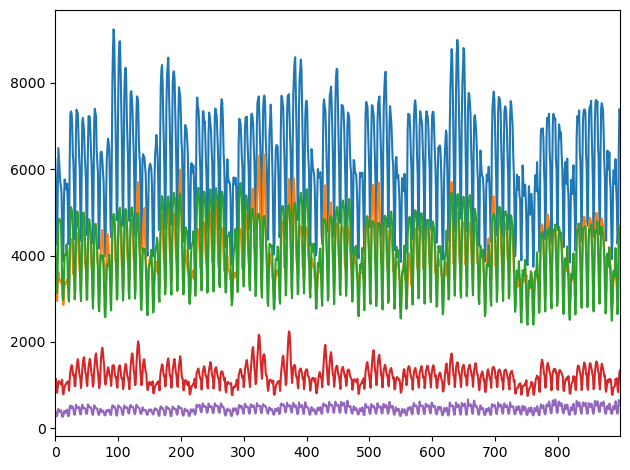

In [97]:
tfms = [ToFloat(), None]
batch_tfms = [
    TSStandardize(
        by_sample=enc_artifact.metadata['norm_by_sample'],
        use_single_batch=enc_artifact.metadata['norm_use_single_batch']
    )
]
dls = get_ts_dls(
    lrp_input, 
    splits=splits, 
    tfms=tfms, 
    bs=enc_artifact.metadata['batch_size'], 
    batch_tfms=batch_tfms
)
dls.show_at(0)

##### Prepare the data

In [98]:
lrp_input = enc_input
print(lrp_input.shape)
lrp_input_strided = lrp_input[::enc_artifact.metadata['stride']]
print(lrp_input_strided.shape)
print(type(lrp_input_strided))

(45555, 5, 900)
(102, 5, 900)
<class 'numpy.ndarray'>


In [107]:
# make sure the input requires a gradient
lrp_input_torch = torch.cuda.FloatTensor(lrp_input_strided)
lrp_input_torch.requires_grad = True
# Ensure input to be in GPU
lrp_input_torch.to('cuda')
lrp_input_torch.shape

torch.Size([102, 5, 900])

#### Load the trained model

In [104]:
#window_size = enc_artifact.metadata['w']
#window_size

In [105]:
#batch_size = enc_artifact.metadata['batch_size']
#batch_size

In [106]:
# Ensure model to be in GPU
model = enc_learner.model.to('cuda')

#### Option 1: composite 

> Using ```EpsilonPlusFlat``` composite

Create a composite instance

In [110]:
from zennit.composites import EpsilonPlusFlat

In [111]:
# create a composite instance
composite = EpsilonPlusFlat()

In [112]:
# compute the output and gradient within the composite's context
def compute_output_and_gradient(model, input_data):
    model.eval()
    with composite.context(model) as modified_model:
        output = modified_model(input_data)
        output.backward(
            gradient=torch.ones_like(input_data),
            retain_graph = True
        ) 
        relevance = torch.autograd.grad(
            output, input_data, 
            torch.ones_like(input_data),
            retain_graph=True
        )
    return output, relevance

In [166]:
# TODO: Revisar por qué salen NaNs
output, relevance = compute_output_and_gradient(model, lrp_input_torch)
relevance = relevance[0]
relevance.shape

torch.Size([102, 5, 900])

##### Reduce relevance dimensions to get an array with a relevance per each feature

In [159]:
def reduce_dimensions(relevance):
    #Get the mean per each feature
    importances = relevance.nanmean(axis=2)
    print(importances.shape)
    #Get a global mean instead of one per sample
    importances_mean = importances.nanmean(dim=0).detach().cpu().numpy()
    print(importances_mean.shape)
    #print(importances_mean)
    #Take care of negative values
    min_importance = min(importances_mean)
    if  min_importance < 0:
        importances_mean = importances_mean - min_importance
    print(min(importances_mean))
    #See as percentage
    importances_sum = np.nansum(importances_mean)
    importances_percentage = (importances_mean/importances_sum)
    print(importances_percentage)
    return importances_percentage

In [167]:
importances = reduce_dimensions(relevance)

torch.Size([102, 5])
(5,)
1.4659871
[0.31020203 0.23860219 0.276854   0.1009251  0.07341679]


##### Visualize

###### Get feature names

In [121]:
features_names = list(df.columns)
features_names

[0, 1, 2, 3, 4]

###### Create auxiliar function to check a diagram bar
> TODO: Think how a heatmap would be sawn as and implement if possible

In [122]:
import matplotlib.pyplot as plt

In [168]:
def plot_features_importance(title, features_names, importances_percentage):
    # Crear diagrama de barras
    plt.figure(figsize=(10, 6))
    plt.bar(features_names, importances_percentage)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title(title + '| Features importance (%)')
    plt.xticks(rotation=45)
    plt.show()

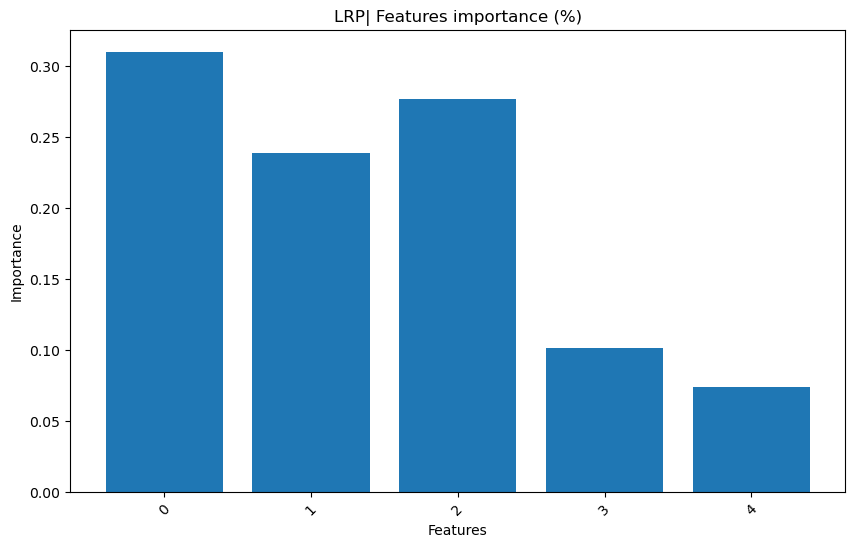

In [161]:
plot_features_importance ('LRP', features_names, importances)

Thus, the two most meaningfull features are

In [135]:
def get_meaningfull_ids(importances, features_names):
    meaningfull_ids = np.argsort(importances)[-2:]
    return [(i,features_names[i], importances[i]) for i in meaningfull_ids], meaningfull_ids

In [202]:
meaningfull_features, meaningfull_ids = get_meaningfull_ids(importances, features_names)
meaningfull_features

[(2, 2, 0.276854), (0, 0, 0.31020203)]

#### Option 2: attributtors
> Using ```SmoothGRad``` attributor as in the example

In [127]:
from zennit.attribution import SmoothGrad

In [142]:
attributor = SmoothGrad(model, noise_level=0.1, n_iter=10)

In [145]:
def compute_output_and_relevance_atributor(model, attributor, input):
    # we do not need a composite to compute vanilla SmoothGrad
    model.eval()
    #with atributor_ as attributor:
    with attributor:
         # gradient/ relevance
         output, relevance = attributor(
             input, 
             torch.ones_like(input)
        )
    print('Attributor:', relevance[:2], relevance.shape)
    return output, relevance

In [146]:
_, relevance_smooth_grad = compute_output_and_relevance_atributor(model, attributor, lrp_input_torch)
print(relevance_smooth_grad.shape)

Attributor: tensor([[[-0.1093, -0.0501, -0.1724,  ..., -0.2987, -0.3601, -0.4019],
         [ 0.0246,  0.0098,  0.0872,  ...,  0.1111,  0.0411,  0.0311],
         [ 0.4455,  0.3984,  0.4368,  ...,  0.4729,  0.4738,  0.4794],
         [-0.5840, -0.6867, -0.6537,  ..., -0.7257, -0.8038, -0.8304],
         [-0.9755, -0.9674, -1.1270,  ..., -1.0004, -0.9983, -1.1039]],

        [[-0.2239, -0.2079, -0.1870,  ..., -0.2556, -0.3287, -0.4537],
         [ 0.0866,  0.0111,  0.0807,  ...,  0.1194, -0.0210,  0.0197],
         [ 0.4452,  0.5163,  0.4645,  ...,  0.5803,  0.5677,  0.4043],
         [-0.5549, -0.6744, -0.8197,  ..., -0.7847, -0.8171, -0.8238],
         [-0.9751, -0.9762, -1.1318,  ..., -1.1162, -1.0093, -1.0326]]],
       device='cuda:0') torch.Size([102, 5, 900])
torch.Size([102, 5, 900])


In [190]:
importances_attributor = reduce_dimensions(relevance_smooth_grad)

torch.Size([102, 5])
(5,)
0.0
[0.22375315 0.27906567 0.39828682 0.0988944  0.        ]


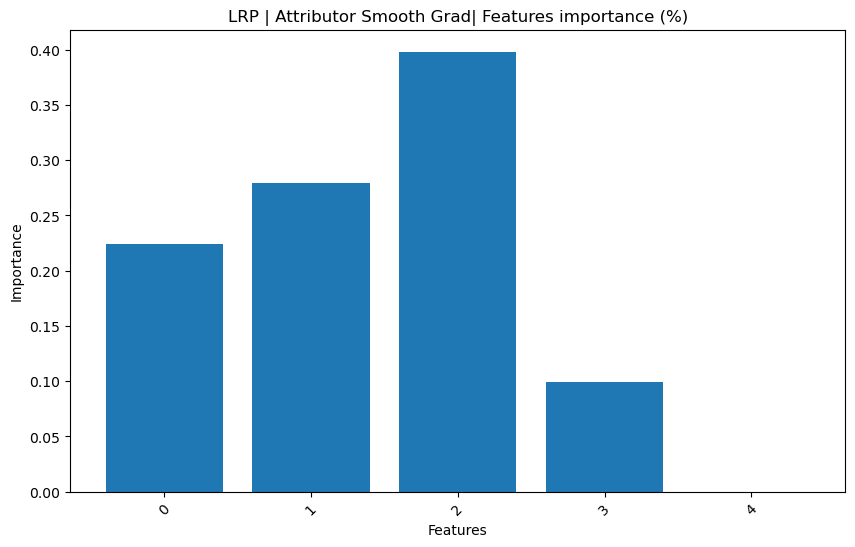

In [171]:
plot_features_importance('LRP | Attributor Smooth Grad', features_names, importances_attributor)

In [174]:
meaningfull_features_attributors, meaningfull_ids_attributors = get_meaningfull_ids(importances_attributor, features_names)
meaningfull_features_attributors

[(1, 1, 0.27906567), (2, 2, 0.39828682)]

In [173]:
# Remember to compare
meaningfull_features

[(2, 2, 0.276854), (0, 0, 0.31020203)]

#### Option 3: Canonizers & Attributor & Rule
> Using ```SequentialMergeBatchNorm``` composite

> and ```Gradient``` attributor

> and ```EpsilonGammaBox``` as rule

In [180]:
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.attribution import Gradient
from zennit.composites import EpsilonGammaBox

In [183]:
model.eval()
canonizers = [SequentialMergeBatchNorm()]
composite = EpsilonGammaBox(low=-3., high=3., canonizers=canonizers)
attributor = Gradient(model, composite)

In [179]:
def compute_output_and_relevance_canonizer_atributor(model, canonizer, attributor, input):
    with attributor:
        output, relevance = attributor(
             input,
             torch.ones_like(input)
        )
    return output, relevance

In [191]:
_, relevance_canonizer_atributor_rule = compute_output_and_relevance_canonizer_atributor(model, canonizer, atributor, lrp_input_torch)
importances_canonizer_atributor_rule = reduce_dimensions(relevance_canonizer_atributor_rule)

torch.Size([102, 5])
(5,)
0.0
[0.22382213 0.27904847 0.39826655 0.09886278 0.        ]


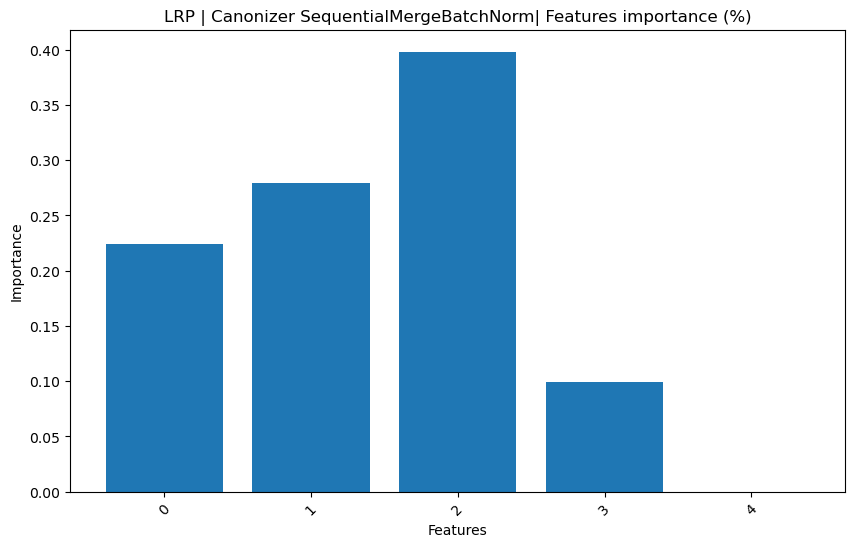

In [194]:
plot_features_importance('LRP | Canonizer SequentialMergeBatchNorm', features_names, importances_canonizer_atributor_rule)

In [197]:
meaningfull_features_canonizer_attributor_rule, meaningfull_ids_canonizer_attributor_rule = get_meaningfull_ids(importances_canonizer_atributor_rule, features_names)
meaningfull_features_canonizer_attributor_rule

[(1, 1, 0.27904847), (2, 2, 0.39826655)]

In [203]:
print("Sumarise")
print("Composite meaningfull features: ", meaningfull_features)
print("Attributor meaningfull features: ", meaningfull_features_attributors)
print("Canonizer & Atributor & Rule meaningfull features: ", meaningfull_features_canonizer_attributor_rule)

Sumarise
Composite meaningfull features:  [(2, 2, 0.276854), (0, 0, 0.31020203)]
Attributor meaningfull features:  [(1, 1, 0.27906567), (2, 2, 0.39828682)]
Canonizer & Atributor & Rule meaningfull features:  [(1, 1, 0.27904847), (2, 2, 0.39826655)]


#### Option 4: Canonizer & Rule
> Using ```SequentialMergeBatchNorm``` composite

> and ```EpsilonGammaBox``` as rule

In [255]:
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.composites import EpsilonGammaBox

In [239]:
model.eval()
canonizer = SequentialMergeBatchNorm()

In [256]:
# compute the output and gradient within the composite's context
def compute_output_and_gradient_canonizer_rule(model, canonizer, input_data):
    model.eval()
    
    instances = canonizer.apply(model)

    #Do something with the model
    output = model(input_data)
    
    relevance, = torch.autograd.grad(
        output, input_data, 
        torch.ones_like(input_data),
        retain_graph=True
    )
    #Remove the canonizer instances to revert the model to its original state
    for instance in instances:
        instance.remove()
    return output, relevance

In [257]:
_, relevance_canonizer_rule = compute_output_and_gradient_canonizer_rule(model, canonizer, lrp_input_torch)

In [258]:
importances_canonizer_rule = reduce_dimensions(relevance_canonizer_rule)

torch.Size([102, 5])
(5,)
0.02056927
[0.3663009  0.32749093 0.27020788 0.03497188 0.00102847]


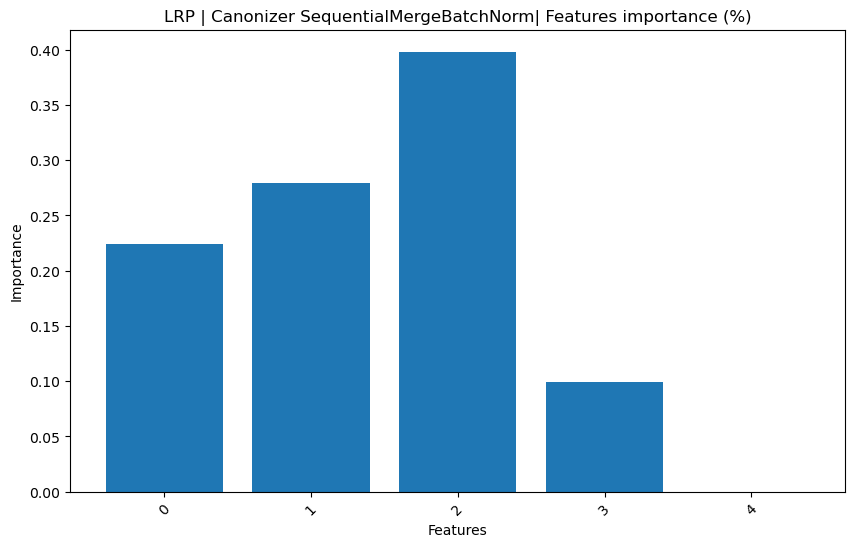

In [259]:
plot_features_importance('LRP | Canonizer SequentialMergeBatchNorm', features_names, importances_canonizer_atributor_rule)

In [261]:
meaningfull_features_canonizer_rule, meaningfull_ids_canonizer_rule = get_meaningfull_ids(importances_canonizer_atributor_rule, features_names)
meaningfull_features_canonizer_rule

[(1, 1, 0.27904847), (2, 2, 0.39826655)]

In [260]:
print("Sumarise")
print("Composite meaningfull features: ", meaningfull_features)
print("Attributor meaningfull features: ", meaningfull_features_attributors)
print("Canonizer & Atributor & Rule meaningfull features: ", meaningfull_features_canonizer_attributor_rule)
print("Canonizer & Rule meaningfull features: ", meaningfull_features_canonizer_rule)

Sumarise
Composite meaningfull features:  [(2, 2, 0.276854), (0, 0, 0.31020203)]
Attributor meaningfull features:  [(1, 1, 0.27906567), (2, 2, 0.39828682)]
Canonizer & Atributor & Rule meaningfull features:  [(1, 1, 0.27904847), (2, 2, 0.39826655)]


<class 'NameError'>: name 'meaningfull_features_canonizer_rule' is not defined